### Application: Heterogeneous Effect of Gender on Wage Using Double Lasso
We use US census data from the year 2012 to analyse the effect of gender and interaction effects of other variables with gender on wage jointly. The dependent variable is the logarithm of the wage, the target variable is female (in combination with other variables). All other variables denote some other socio-economic characteristics, e.g. marital status, education, and experience. For a detailed description of the variables we refer to the help page.\

This application is similar to tho one of Testing the Convergence Hypothesis as both use double lasso to determine if a variable D (gender in this case and initial wealth in the other case) explais an outcome Y.

In [1]:
#Packages

using RData, LinearAlgebra, GLM, DataFrames, Statistics, Random, Distributions, 
DataStructures, NamedArrays, PrettyTables, StatsModels, Combinatorics, Plots

import CodecBzip2

In [2]:
cps2012 = load("C:/Users/Alvaro/Documents/ML/data/cps2012.RData")

Dict{String, Any} with 1 entry:
  "data" => 29217×23 DataFrame…

In [3]:
keys(cps2012) 

KeySet for a Dict{String, Any} with 1 entry. Keys:
  "data"

In [4]:
cps2012 = cps2012["data"]
names(cps2012)

23-element Vector{String}:
 "year"
 "lnw"
 "female"
 "widowed"
 "divorced"
 "separated"
 "nevermarried"
 "hsd08"
 "hsd911"
 "hsg"
 "cg"
 "ad"
 "mw"
 "so"
 "we"
 "exp1"
 "exp2"
 "exp3"
 "exp4"
 "weight"
 "married"
 "ne"
 "sc"

In [5]:
    # couples variables combinations 
    combinations_upto(x, n) = Iterators.flatten(combinations(x, i) for i in 1:n)

    # combinations without same couple
    expand_exp(args, deg::ConstantTerm) =
        tuple(((&)(terms...) for terms in combinations_upto(args, deg.n))...)

    StatsModels.apply_schema(t::FunctionTerm{typeof(^)}, sch::StatsModels.Schema, ctx::Type) =
        apply_schema.(expand_exp(t.args_parsed...), Ref(sch), ctx)

In [6]:
# Basic model 


reg = @formula(lnw ~ -1 + female + female&(widowed + divorced + separated + nevermarried +
hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 + exp3) + (widowed +
divorced + separated + nevermarried + hsd08 + hsd911 + hsg + cg + ad + mw + so +
we + exp1 + exp2 + exp3)^2 )


formula_basic = apply_schema(reg, schema(reg, cps2012))

#Names of the variable

coefnames(formula_basic)

("lnw", Any["female", "widowed", "divorced", "separated", "nevermarried", "hsd08", "hsd911", "hsg", "cg", "ad"  …  "female & hsd911", "female & hsg", "female & cg", "female & ad", "female & mw", "female & so", "female & we", "female & exp1", "female & exp2", "female & exp3"])

In [7]:
#Define our varibles for the regression

Y = select(cps2012,:lnw)  # uptcome variable
control = coefnames(formula_basic)[2]  # regresors control (W)
names_col = Symbol.(control)  # string to Symbol to create varaible's name 

136-element Vector{Symbol}:
 :female
 :widowed
 :divorced
 :separated
 :nevermarried
 :hsd08
 :hsd911
 :hsg
 :cg
 :ad
 :mw
 :so
 :we
 ⋮
 Symbol("female & nevermarried")
 Symbol("female & hsd08")
 Symbol("female & hsd911")
 Symbol("female & hsg")
 Symbol("female & cg")
 Symbol("female & ad")
 Symbol("female & mw")
 Symbol("female & so")
 Symbol("female & we")
 Symbol("female & exp1")
 Symbol("female & exp2")
 Symbol("female & exp3")

In [8]:
#transformation to an array

X = StatsModels.modelmatrix(formula_basic,cps2012)

29217×136 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  22.0  4.84    10.648
 1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  30.0  9.0     27.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0   0.0  0.0      0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  14.0  1.96     2.744
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0   0.0  0.0      0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0     0.0  0.0   0.0  0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0      0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  15.5  2.4025   3.72388
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0   0.0  0.0      0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   7.0  0.49     0.343
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0      0.0
 ⋮            

In [9]:
#Transformation to DataFrame
X = DataFrame(X, names_col)

,female,widowed,divorced,separated,nevermarried,hsd08,hsd911,hsg
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Function to get index of constant columns   

cons_column = []

for i in 1:size(X,2)
    if var(X[!,i]) == 0
        append!(cons_column  , i)      
    end       
end

In [11]:
# Drop constant columns 

names(X)[cons_column]
select!(X, Not(names(X)[cons_column]))

,female,widowed,divorced,separated,nevermarried,hsd08,hsd911,hsg
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# get the mean of variables
function desv_mean(a)
    a = Matrix(a)   # dataframe to matrix 
    A = mean(a, dims = 1)
    M = zeros(Float64, size(X,1), size(X,2))
    
    for i in 1:size(a,2)
          M[:,i] = a[:,i] .- A[i]
    end
    
    return M
end    


# Matrix Model & demean

X = DataFrame(desv_mean(X), names(X)) # Dataframe and names 

,female,widowed,divorced,separated,nevermarried,hsd08,hsd911
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.571243,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789
2,0.571243,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,0.977821
3,-0.428757,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789
4,0.571243,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789
5,-0.428757,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789
6,-0.428757,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789
7,-0.428757,-0.00797481,-0.113393,-0.0165999,0.843653,-0.0041072,-0.0221789
8,-0.428757,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789
9,-0.428757,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789


In [13]:
# index to get columns that contains female

index = []

for i in 1:size(X,2)  
        if contains( names(X)[i] , "female")
            append!(index, i)
        end  
end

In [14]:
for i in index
    print(names(X)[i], "\n")
end

female
female & widowed
female & divorced
female & separated
female & nevermarried
female & hsd08
female & hsd911
female & hsg
female & cg
female & ad
female & mw
female & so
female & we
female & exp1
female & exp2
female & exp3


In [15]:
# Control variables 

W = select(X, Not(names(X)[index]))

,widowed,divorced,separated,nevermarried,hsd08,hsd911,hsg
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789,-0.247288
2,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,0.977821,-0.247288
3,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789,0.752712
4,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789,0.752712
5,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789,-0.247288
6,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789,0.752712
7,-0.00797481,-0.113393,-0.0165999,0.843653,-0.0041072,-0.0221789,0.752712
8,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789,-0.247288
9,-0.00797481,-0.113393,-0.0165999,-0.156347,-0.0041072,-0.0221789,-0.247288


### HDM Package

In [16]:
# load HDM package

include("C:/Users/Alvaro/Documents/ML/Labs/hdmjl/hdmjl.jl")

In [17]:
table = NamedArray(zeros(16, 2))

j = 0

X_resid = Vector{Float64}()  # empty vector - float 

for i in index

j = j + 1
        
#first step
D = select(X, names(X)[i])
    
D_reg_0  = rlasso_arg( W, D, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

D_resid =  rlasso(D_reg_0)["residuals"]

    
append!( X_resid, D_resid )
    
end

In [18]:
#second step

Y_reg_0  = rlasso_arg( W, Y, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

Y_resid = rlasso(Y_reg_0)["residuals"]

X_resid = reshape(X_resid, length(Y_resid), length(index))  # reshape stacked vector to mattrix 

29217×16 Matrix{Float64}:
  0.567918  -1.30104e-17  …   12.8248     2.8194       6.32254
  0.745968  -1.30104e-17      21.3128     6.2255      18.6011
 -0.353627  -1.30104e-17      -6.61143   -1.23522     -2.79376
  0.646373  -1.30104e-17       9.46843    1.40668      1.63816
 -0.432082  -1.30104e-17      -6.26339   -0.951552    -1.36754
 -0.353627  -1.30104e-17  …   -8.27531   -1.92782     -4.93616
 -0.353627  -1.30104e-17     -12.435     -4.23126    -14.3806
 -0.432082  -1.30104e-17      -9.79914   -2.30178     -5.26157
 -0.432082  -1.30104e-17      -6.26339   -0.951552    -1.36754
  0.567918  -1.30104e-17       9.02862    1.38786      2.21225
 -0.353627  -1.30104e-17  …   -5.77949   -0.937951    -2.00022
  0.567918  -1.30104e-17       4.06438    0.269973     0.261467
 -0.432082  -1.30104e-17      -4.80749   -0.567165    -0.592691
  ⋮                       ⋱                            ⋮
  0.60337   -1.30104e-17  …    8.73661    1.29845      2.00746
 -0.318174  -1.30104e-17      -4.53

In [19]:
# third step
    
Lasso_HDM = lm(X_resid, Y_resid)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────────
           Coef.  Std. Error      t  Pr(>|t|)   Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────
x1   -0.16132     0.0389166   -4.15    <1e-04  -0.237598   -0.0850416
x2    0.144424    0.0906545    1.59    0.1111  -0.0332626   0.322111
x3    0.140591    0.0221825    6.34    <1e-09   0.097112    0.184069
x4    0.0524948   0.0532334    0.99    0.3241  -0.0518451   0.156835
x5    0.171391    0.0202072    8.48    <1e-16   0.131784    0.210998
x6   -0.0492215   0.121268    -0.41    0.6848  -0.286911    0.188468
x7   -0.142358    0.051854    -2.75    0.0060  -0.243994   -0.0407218
x8   -0.0219008   0.0192306   -1.14    0.2548  -0.0595936   0.015792
x9    0.00682406  0.0183583    0.37    0.7101  -0.029159    0.0428071
x10  -0.0200885   0.021893    -0.92

In [23]:
# Now lets put the results in a DataFrame

table1 = NamedArray(zeros(16, 7))

for i in 1:16
    for j in 1:6
        table1[i,j+1] = GLM.coeftable(Lasso_HDM).cols[j][i]
    end
end

T = DataFrame(table1, [ :"Variable", :"Estimate", :"Std.error", :"t", :"P-value", :"Lower-bound", :"Upper-bound"])

T[!,:Variable] = string.(T[!,:Variable])  # string - first column 

for i in 1:16

T[i,1] = names(X)[index][i]

end


header = (["Variable", "Estimate", "Std.error", "t-value", "P-value", "Lower-bound", "Upper-bound"])

pretty_table(T; backend = Val(:html), header = header, formatters=ft_round(5), alignment=:c)

Variable,Estimate,Std.error,t-value,P-value,Lower-bound,Upper-bound
female,-0.16132,0.03892,-4.14527,3.0e-5,-0.2376,-0.08504
female & widowed,0.14442,0.09065,1.59313,0.11114,-0.03326,0.32211
female & divorced,0.14059,0.02218,6.33792,0.0,0.09711,0.18407
female & separated,0.05249,0.05323,0.98612,0.32408,-0.05185,0.15683
female & nevermarried,0.17139,0.02021,8.48165,0.0,0.13178,0.211
female & hsd08,-0.04922,0.12127,-0.40589,0.68482,-0.28691,0.18847
female & hsd911,-0.14236,0.05185,-2.74536,0.00605,-0.24399,-0.04072
female & hsg,-0.0219,0.01923,-1.13885,0.25477,-0.05959,0.01579
female & cg,0.00682,0.01836,0.37172,0.71011,-0.02916,0.04281
female & ad,-0.02009,0.02189,-0.91758,0.35885,-0.063,0.02282


In [24]:
# Errors

xerror = T[!,2] .- T[!,6]

16-element Named Vector{Float64}
A  │ 
───┼──────────
1  │ 0.0762783
2  │  0.177687
3  │ 0.0434786
4  │   0.10434
5  │ 0.0396071
6  │   0.23769
7  │  0.101636
8  │ 0.0376928
9  │  0.035983
10 │ 0.0429112
11 │ 0.0375626
12 │ 0.0379255
13 │ 0.0414971
14 │ 0.0106779
15 │  0.060336
16 │ 0.0110567

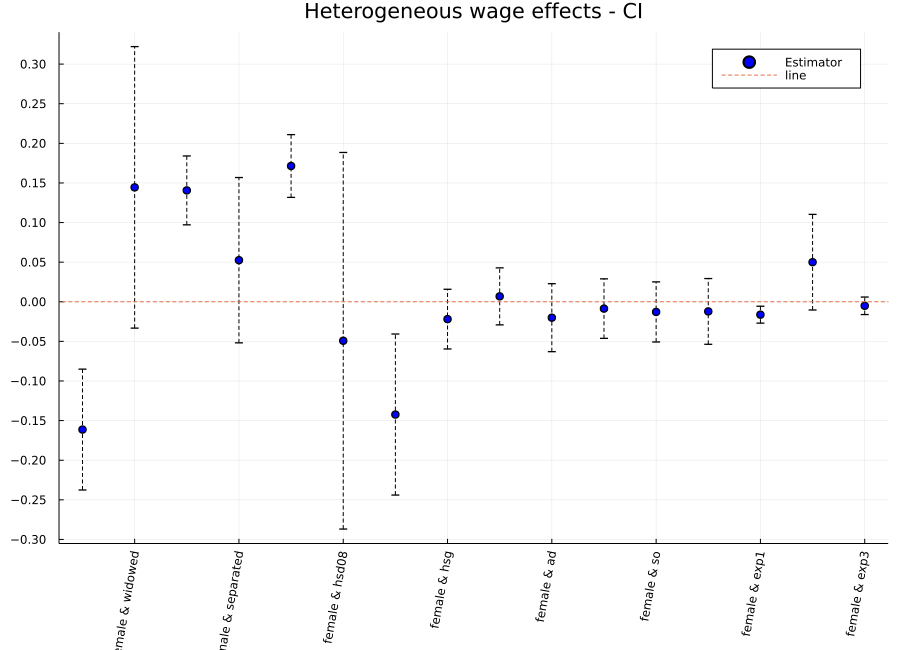

In [79]:
#Coeficient plot of female variables

scatter(names(X)[index], T[!,2] , label = "Estimator", yerrors = xerror, 
        ytick = -2:0.05:2, linestyle = :dash, seriescolor=:blue)
plot!(size=(900,650), title="Heterogeneous wage effects - CI", xrotation=80)
hline!( [0], linestyle = :dash , label = "line")